<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/shift_scheduling_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ortools
!pip install absl
!pip install protobuf

ERROR: Could not find a version that satisfies the requirement absl (from versions: none)
ERROR: No matching distribution found for absl


Solution 0, time = 0.09 s, objective = 423.0
Solution 1, time = 0.10 s, objective = 403.0
Solution 2, time = 0.13 s, objective = 315.0
Solution 3, time = 0.41 s, objective = 225.0
Solution 4, time = 0.46 s, objective = 151.0
Solution 5, time = 0.49 s, objective = 146.0
Solution 6, time = 0.50 s, objective = 134.0
Solution 7, time = 0.54 s, objective = 131.0
Solution 8, time = 0.77 s, objective = 126.0
Solution 9, time = 1.15 s, objective = 124.0
Solution 10, time = 1.40 s, objective = 122.0
Solution 11, time = 1.52 s, objective = 97.0
Solution 12, time = 1.81 s, objective = 89.0
Solution 13, time = 1.91 s, objective = 69.0
Solution 14, time = 1.93 s, objective = 65.0
Solution 15, time = 2.33 s, objective = 62.0
Solution 16, time = 2.42 s, objective = 60.0
Solution 17, time = 2.44 s, objective = 54.0
Solution 18, time = 2.58 s, objective = 41.0
Solution 19, time = 5.46 s, objective = 38.0

          M T W T F S S M T W T F S S M T W T F S S 
worker 0: O M N N A O A A A O A O A A M N N A

/tmp/ipython-input-699126355.py:466: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  color_matrix = df.applymap(lambda x: shift_colors[x])


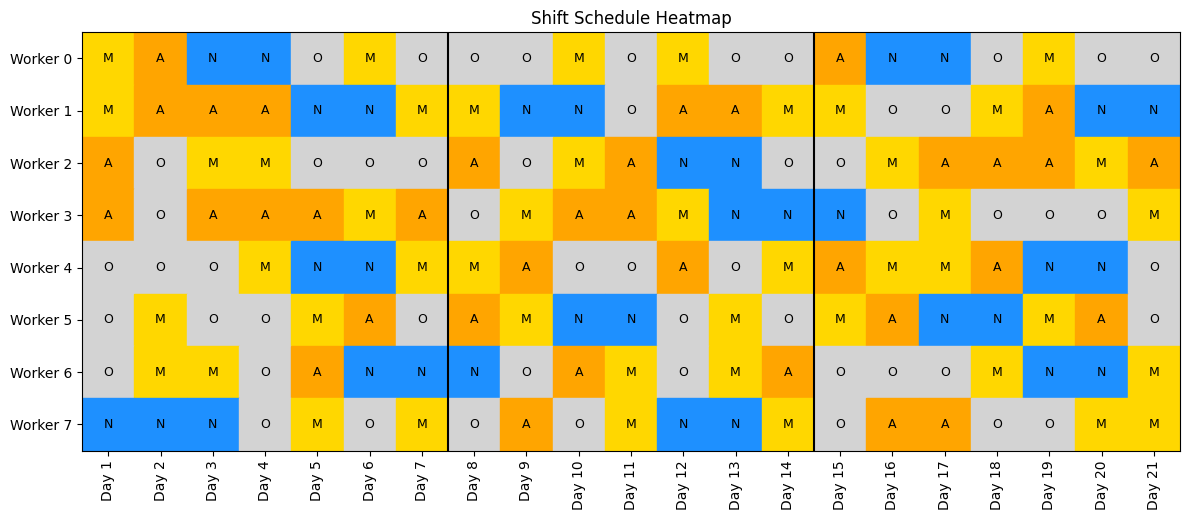

In [11]:

from ortools.sat.python import cp_model


def negated_bounded_span(
    works: list[cp_model.BoolVarT], start: int, length: int
) -> list[cp_model.BoolVarT]:
    """Filters an isolated sub-sequence of variables assigned to True.

    Extract the span of Boolean variables [start, start + length), negate them,
    and if there is variables to the left/right of this span, surround the span by
    them in non negated form.

    Args:
      works: a list of variables to extract the span from.
      start: the start to the span.
      length: the length of the span.

    Returns:
      a list of variables which conjunction will be false if the sub-list is
      assigned to True, and correctly bounded by variables assigned to False,
      or by the start or end of works.
    """
    sequence = []
    # left border (start of works, or works[start - 1])
    if start > 0:
        sequence.append(works[start - 1])
    for i in range(length):
        sequence.append(~works[start + i])
    # right border (end of works or works[start + length])
    if start + length < len(works):
        sequence.append(works[start + length])
    return sequence


def add_soft_sequence_constraint(
    model: cp_model.CpModel,
    works: list[cp_model.BoolVarT],
    hard_min: int,
    soft_min: int,
    min_cost: int,
    soft_max: int,
    hard_max: int,
    max_cost: int,
    prefix: str,
) -> tuple[list[cp_model.BoolVarT], list[int]]:
    """Sequence constraint on true variables with soft and hard bounds.

    This constraint look at every maximal contiguous sequence of variables
    assigned to true. If forbids sequence of length < hard_min or > hard_max.
    Then it creates penalty terms if the length is < soft_min or > soft_max.

    Args:
      model: the sequence constraint is built on this model.
      works: a list of Boolean variables.
      hard_min: any sequence of true variables must have a length of at least
        hard_min.
      soft_min: any sequence should have a length of at least soft_min, or a
        linear penalty on the delta will be added to the objective.
      min_cost: the coefficient of the linear penalty if the length is less than
        soft_min.
      soft_max: any sequence should have a length of at most soft_max, or a linear
        penalty on the delta will be added to the objective.
      hard_max: any sequence of true variables must have a length of at most
        hard_max.
      max_cost: the coefficient of the linear penalty if the length is more than
        soft_max.
      prefix: a base name for penalty literals.

    Returns:
      a tuple (variables_list, coefficient_list) containing the different
      penalties created by the sequence constraint.
    """
    cost_literals = []
    cost_coefficients = []

    # Forbid sequences that are too short.
    for length in range(1, hard_min):
        for start in range(len(works) - length + 1):
            model.add_bool_or(negated_bounded_span(works, start, length))

    # Penalize sequences that are below the soft limit.
    if min_cost > 0:
        for length in range(hard_min, soft_min):
            for start in range(len(works) - length + 1):
                span = negated_bounded_span(works, start, length)
                name = f": under_span(start={start}, length={length})"
                lit = model.new_bool_var(prefix + name)
                span.append(lit)
                model.add_bool_or(span)
                cost_literals.append(lit)
                # We filter exactly the sequence with a short length.
                # The penalty is proportional to the delta with soft_min.
                cost_coefficients.append(min_cost * (soft_min - length))

    # Penalize sequences that are above the soft limit.
    if max_cost > 0:
        for length in range(soft_max + 1, hard_max + 1):
            for start in range(len(works) - length + 1):
                span = negated_bounded_span(works, start, length)
                name = f": over_span(start={start}, length={length})"
                lit = model.new_bool_var(prefix + name)
                span.append(lit)
                model.add_bool_or(span)
                cost_literals.append(lit)
                # Cost paid is max_cost * excess length.
                cost_coefficients.append(max_cost * (length - soft_max))

    # Just forbid any sequence of true variables with length hard_max + 1
    for start in range(len(works) - hard_max):
        model.add_bool_or([~works[i] for i in range(start, start + hard_max + 1)])
    return cost_literals, cost_coefficients


def add_soft_sum_constraint(
    model: cp_model.CpModel,
    works: list[cp_model.BoolVarT],
    hard_min: int,
    soft_min: int,
    min_cost: int,
    soft_max: int,
    hard_max: int,
    max_cost: int,
    prefix: str,
) -> tuple[list[cp_model.IntVar], list[int]]:
    """sum constraint with soft and hard bounds.

    This constraint counts the variables assigned to true from works.
    If forbids sum < hard_min or > hard_max.
    Then it creates penalty terms if the sum is < soft_min or > soft_max.

    Args:
      model: the sequence constraint is built on this model.
      works: a list of Boolean variables.
      hard_min: any sequence of true variables must have a sum of at least
        hard_min.
      soft_min: any sequence should have a sum of at least soft_min, or a linear
        penalty on the delta will be added to the objective.
      min_cost: the coefficient of the linear penalty if the sum is less than
        soft_min.
      soft_max: any sequence should have a sum of at most soft_max, or a linear
        penalty on the delta will be added to the objective.
      hard_max: any sequence of true variables must have a sum of at most
        hard_max.
      max_cost: the coefficient of the linear penalty if the sum is more than
        soft_max.
      prefix: a base name for penalty variables.

    Returns:
      a tuple (variables_list, coefficient_list) containing the different
      penalties created by the sequence constraint.
    """
    cost_variables = []
    cost_coefficients = []
    sum_var = model.new_int_var(hard_min, hard_max, "")
    # This adds the hard constraints on the sum.
    model.add(sum_var == sum(works))

    # Penalize sums below the soft_min target.
    if soft_min > hard_min and min_cost > 0:
        delta = model.new_int_var(-len(works), len(works), "")
        model.add(delta == soft_min - sum_var)
        # TODO(user): Compare efficiency with only excess >= soft_min - sum_var.
        excess = model.new_int_var(0, 7, prefix + ": under_sum")
        model.add_max_equality(excess, [delta, 0])
        cost_variables.append(excess)
        cost_coefficients.append(min_cost)

    # Penalize sums above the soft_max target.
    if soft_max < hard_max and max_cost > 0:
        delta = model.new_int_var(-7, 7, "")
        model.add(delta == sum_var - soft_max)
        excess = model.new_int_var(0, 7, prefix + ": over_sum")
        model.add_max_equality(excess, [delta, 0])
        cost_variables.append(excess)
        cost_coefficients.append(max_cost)

    return cost_variables, cost_coefficients


def solve_shift_scheduling():
    """Solves the shift scheduling problem."""
    # Data
    num_employees = 8
    num_weeks = 3
    shifts = ["O", "M", "A", "N"]

    # Fixed assignment: (employee, shift, day).
    # This fixes the first 2 days of the schedule.
    fixed_assignments = [
        (0, 0, 0),
        (1, 0, 0),
        (2, 1, 0),
        (3, 1, 0),
        (4, 2, 0),
        (5, 2, 0),
        (6, 2, 3),
        (7, 3, 0),
        (0, 1, 1),
        (1, 1, 1),
        (2, 2, 1),
        (3, 2, 1),
        (4, 2, 1),
        (5, 0, 1),
        (6, 0, 1),
        (7, 3, 1),
    ]

    # Request: (employee, shift, day, weight)
    # A negative weight indicates that the employee desire this assignment.
    requests = [
        # Employee 3 does not want to work on the first Saturday (negative weight
        # for the Off shift).
        (3, 0, 5, -2),
        # Employee 5 wants a night shift on the second Thursday (negative weight).
        (5, 3, 10, -2),
        # Employee 2 does not want a night shift on the first Friday (positive
        # weight).
        (2, 3, 4, 4),
    ]

    # Shift constraints on continuous sequence :
    #     (shift, hard_min, soft_min, min_penalty,
    #             soft_max, hard_max, max_penalty)
    shift_constraints = [
        # One or two consecutive days of rest, this is a hard constraint.
        (0, 1, 1, 0, 2, 2, 0),
        # between 2 and 3 consecutive days of night shifts, 1 and 4 are
        # possible but penalized.
        (3, 1, 2, 20, 3, 4, 5),
    ]

    # Weekly sum constraints on shifts days:
    #     (shift, hard_min, soft_min, min_penalty,
    #             soft_max, hard_max, max_penalty)
    weekly_sum_constraints = [
        # Constraints on rests per week.
        (0, 1, 2, 7, 2, 3, 4),
        # At least 1 night shift per week (penalized). At most 4 (hard).
        (3, 0, 1, 3, 4, 4, 0),
    ]

    # Penalized transitions:
    #     (previous_shift, next_shift, penalty (0 means forbidden))
    penalized_transitions = [
        # Afternoon to night has a penalty of 4.
        (2, 3, 4),
        # Night to morning is forbidden.
        (3, 1, 0),
    ]

    # daily demands for work shifts (morning, afternoon, night) for each day
    # of the week starting on Monday.
    weekly_cover_demands = [
        (2, 3, 1),  # Monday
        (2, 3, 1),  # Tuesday
        (2, 2, 2),  # Wednesday
        (2, 3, 1),  # Thursday
        (2, 2, 2),  # Friday
        (1, 2, 3),  # Saturday
        (1, 3, 1),  # Sunday
    ]

    # Penalty for exceeding the cover constraint per shift type.
    excess_cover_penalties = (2, 2, 5)

    num_days = num_weeks * 7
    num_shifts = len(shifts)

    model = cp_model.CpModel()

    work = {}
    for e in range(num_employees):
        for s in range(num_shifts):
            for d in range(num_days):
                work[e, s, d] = model.new_bool_var(f"work{e}_{s}_{d}")

    # Linear terms of the objective in a minimization context.
    obj_int_vars: list[cp_model.IntVar] = []
    obj_int_coeffs: list[int] = []
    obj_bool_vars: list[cp_model.BoolVarT] = []
    obj_bool_coeffs: list[int] = []

    # Exactly one shift per day.
    for e in range(num_employees):
        for d in range(num_days):
            model.add_exactly_one(work[e, s, d] for s in range(num_shifts))

    # Fixed assignments.
    for e, s, d in fixed_assignments:
        model.add(work[e, s, d] == 1)

    # Employee requests
    for e, s, d, w in requests:
        obj_bool_vars.append(work[e, s, d])
        obj_bool_coeffs.append(w)

    # Shift constraints
    for ct in shift_constraints:
        shift, hard_min, soft_min, min_cost, soft_max, hard_max, max_cost = ct
        for e in range(num_employees):
            works = [work[e, shift, d] for d in range(num_days)]
            variables, coeffs = add_soft_sequence_constraint(
                model,
                works,
                hard_min,
                soft_min,
                min_cost,
                soft_max,
                hard_max,
                max_cost,
                f"shift_constraint(employee {e}, shift {shift})",
            )
            obj_bool_vars.extend(variables)
            obj_bool_coeffs.extend(coeffs)

    # Weekly sum constraints
    for ct in weekly_sum_constraints:
        shift, hard_min, soft_min, min_cost, soft_max, hard_max, max_cost = ct
        for e in range(num_employees):
            for w in range(num_weeks):
                works = [work[e, shift, d + w * 7] for d in range(7)]
                variables, coeffs = add_soft_sum_constraint(
                    model,
                    works,
                    hard_min,
                    soft_min,
                    min_cost,
                    soft_max,
                    hard_max,
                    max_cost,
                    f"weekly_sum_constraint(employee {e}, shift {shift}, week {w})",
                )
                obj_int_vars.extend(variables)
                obj_int_coeffs.extend(coeffs)

    # Penalized transitions
    for previous_shift, next_shift, cost in penalized_transitions:
        for e in range(num_employees):
            for d in range(num_days - 1):
                transition = [
                    ~work[e, previous_shift, d],
                    ~work[e, next_shift, d + 1],
                ]
                if cost == 0:
                    model.add_bool_or(transition)
                else:
                    trans_var = model.new_bool_var(
                        f"transition (employee={e}, day={d})"
                    )
                    transition.append(trans_var)
                    model.add_bool_or(transition)
                    obj_bool_vars.append(trans_var)
                    obj_bool_coeffs.append(cost)

    # Cover constraints
    for s in range(1, num_shifts):
        for w in range(num_weeks):
            for d in range(7):
                works = [work[e, s, w * 7 + d] for e in range(num_employees)]
                # Ignore Off shift.
                min_demand = weekly_cover_demands[d][s - 1]
                worked = model.new_int_var(min_demand, num_employees, "")
                model.add(worked == sum(works))
                over_penalty = excess_cover_penalties[s - 1]
                if over_penalty > 0:
                    name = f"excess_demand(shift={s}, week={w}, day={d})"
                    excess = model.new_int_var(0, num_employees - min_demand, name)
                    model.add(excess == worked - min_demand)
                    obj_int_vars.append(excess)
                    obj_int_coeffs.append(over_penalty)

    # Objective
    model.minimize(
        sum(obj_bool_vars[i] * obj_bool_coeffs[i] for i in range(len(obj_bool_vars)))
        + sum(obj_int_vars[i] * obj_int_coeffs[i] for i in range(len(obj_int_vars)))
    )


    # Solve the model.
    solver = cp_model.CpSolver()
    solution_printer = cp_model.ObjectiveSolutionPrinter()
    solver.parameters.max_time_in_seconds = 10

    status = solver.solve(model, solution_printer)

    # Print solution.
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print()
        header = "          "
        for w in range(num_weeks):
            header += "M T W T F S S "
        print(header)
        for e in range(num_employees):
            schedule = ""
            for d in range(num_days):
                for s in range(num_shifts):
                    if solver.boolean_value(work[e, s, d]):
                        schedule += shifts[s] + " "
            print(f"worker {e}: {schedule}")
        print()
        print("Penalties:")
        for i, var in enumerate(obj_bool_vars):
            if solver.boolean_value(var):
                penalty = obj_bool_coeffs[i]
                if penalty > 0:
                    print(f"  {var.name} violated, penalty={penalty}")
                else:
                    print(f"  {var.name} fulfilled, gain={-penalty}")

        for i, var in enumerate(obj_int_vars):
            if solver.value(var) > 0:
                print(
                    f"  {var.name} violated by {solver.value(var)}, linear"
                    f" penalty={obj_int_coeffs[i]}"
                )

    print()
    print(solver.response_stats())

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Map shift index to label & color
    shift_labels = {0: "M", 1: "A", 2: "O", 3: "N"}
    shift_colors = {"M": "#FFD700",  # yellow
                    "A": "#FFA500",  # orange
                    "O": "#D3D3D3",  # light gray
                    "N": "#1E90FF"}  # blue

    num_employees = 8
    num_days = 21
    num_shifts = 4  # M, A, O, N

    # Build schedule table from solver
    schedule = []
    for e in range(num_employees):
        row = []
        for d in range(num_days):
            for s in range(num_shifts):
                if solver.boolean_value(work[e, s, d]) == 1:
                    row.append(shift_labels[s])
                    break
        schedule.append(row)

    # Convert to DataFrame
    df = pd.DataFrame(schedule,
                      index=[f"Worker {i}" for i in range(num_employees)],
                      columns=[f"Day {i+1}" for i in range(num_days)])

    # Create numeric matrix for coloring
    color_matrix = df.applymap(lambda x: shift_colors[x])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, worker in enumerate(df.index):
        for j, day in enumerate(df.columns):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color_matrix.iloc[i, j]))
            ax.text(j + 0.5, i + 0.5, df.iloc[i, j],
                    ha="center", va="center", fontsize=9)
    for week_end in range(7, num_days, 7):
        ax.axvline(week_end, color='black', linewidth=1.5)

    ax.set_xlim(0, num_days)
    ax.set_ylim(0, num_employees)
    ax.set_xticks(np.arange(num_days) + 0.5)
    ax.set_xticklabels(df.columns, rotation=90)
    ax.set_yticks(np.arange(num_employees) + 0.5)
    ax.set_yticklabels(df.index)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title("Shift Schedule Heatmap")

    plt.tight_layout()
    plt.show()



def main():
    solve_shift_scheduling()


if __name__ == "__main__":
    main()